In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('baseline_database_codes_RA_group3.xlsx')  # Load Excel file

# Select columns from 'carni_rosse' to 'margarina' and 'DAS28'
columns_to_select = df.loc[:, 'carni_rosse':'margarina'].columns.tolist()
columns_to_select.append('DAS28')
# Add columns ETA_VISITA  SESSO  BMI  DURATA_MALATTIA  Fattore_reumatoide  STEROIDI  bDMARDs  Fumatore
confounders = ['ETA_VISITA', 'SESSO', 'BMI', 'DURATA_MALATTIA', 'Fattore_reumatoide', 'STEROIDI', 'bDMARDs', 'Fumatore']
columns_to_select.extend(confounders)
# exclude 'acqua' and salt/sugar/oil columns
columns_to_exclude = ['acqua', 'sale_cottura', 'sale_dopo_cottura', 'zucchero_aggiunto', 'dolcificante', 'olio_oliva', 'olio_semi']

for col in columns_to_exclude:
    if col in columns_to_select:
        columns_to_select.remove(col)

# Create new database with selected columns
new_database = df[columns_to_select].copy()

expl why i included them as confounders:
ETA_VISITA (Age):
Age influences both dietary habits and RA severity. Older patients may have different diets and disease progression, so age can confound the relationship between diet and RA activity.

SESSO (Sex):
RA prevalence and immune responses differ by sex, and men and women often have different dietary patterns. Controlling for sex avoids biased associations.

BMI:
Body mass index is linked to systemic inflammation and may affect RA activity. It also relates to diet quality and quantity, making it a key confounder.

DURATA_MALATTIA (Disease duration):
How long someone has had RA impacts disease activity and potentially dietary adjustments over time. Longer disease duration may confound observed effects.

Fattore_reumatoide (Rheumatoid factor status):
Presence of RF is associated with more severe RA and could influence both disease activity and dietary choices (e.g., anti-inflammatory diets).

STEROIDI (Steroid use):
Steroids affect inflammation and symptoms directly and may change patients’ appetite or metabolism, influencing dietary intake.

bDMARDs (Biologic treatments):
These medications modulate immune response and RA activity strongly. They can also impact patients’ lifestyle or diet, confounding the relationship.

Fumatore (Smoking status):
Smoking is a major risk factor for RA and affects inflammation. It is also associated with different lifestyle and dietary habits.

In [3]:
new_database.head()

,carni_rosse,maiale,fast.food,carni_bianca,carni_processata,merluzzo_sogliola,sgombro_lanzardo,pesce_spada,masculino_alici,tonno,...,margarina,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,2-3/settimana,2/mese,mai,2/mese,2-3/settimana,2/mese,mai,mai,mai,1/mese,...,mai,3.660762,40.59,Maschio,26.312811,7.61,VERO,VERO,VERO,Fumatore
1,2-3/settimana,2/mese,mai,2-3/settimana,1/settimana,2/mese,mai,mai,1/mese,1/settimana,...,mai,1.796643,37.38,Femmina,21.551020,11.64,FALSO,FALSO,FALSO,Non fumatore
2,2-3/settimana,2-3/settimana,mai,2-3/settimana,1/mese,2/mese,mai,2/mese,2-3/settimana,4-5/settimana,...,2/mese,2.465101,40.36,Femmina,20.069204,8.61,VERO,FALSO,FALSO,Non fumatore
3,2-3/settimana,mai,mai,2-3/settimana,2-3/settimana,1/settimana,mai,1/mese,mai,2/mese,...,mai,3.133907,50.41,Femmina,25.099502,29.62,FALSO,VERO,FALSO,Ex-fumatore
4,1/settimana,mai,mai,2/mese,1/mese,mai,2/mese,1/mese,1/mese,2/mese,...,mai,2.794231,67.70,Femmina,30.859375,13.18,FALSO,FALSO,FALSO,Ex-fumatore


In [4]:
# vero-1, falso-0 for categorical columns (Fattore_reumatoide	STEROIDI	bDMARDs)
categorical_columns = ['Fattore_reumatoide', 'STEROIDI', 'bDMARDs']
for col in categorical_columns:
    new_database[col] = new_database[col].map({'VERO': 1, 'FALSO': 0})

# SESSO column: 0 for 'M', 1 for 'F'
new_database['SESSO'] = new_database['SESSO'].map({'Maschio': 0, 'Femmina': 1})

# Fumatore column:0,1,2 for 'non fumatori', 'ex fumatori', 'fumatori'
new_database['Fumatore'] = new_database['Fumatore'].map({'Non fumatore': 0, 'Ex-fumatore': 1, 'Fumatore': 2})

new_database['DAS28'] = new_database['DAS28'].astype(float)

new_database.head()

,carni_rosse,maiale,fast.food,carni_bianca,carni_processata,merluzzo_sogliola,sgombro_lanzardo,pesce_spada,masculino_alici,tonno,...,margarina,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,2-3/settimana,2/mese,mai,2/mese,2-3/settimana,2/mese,mai,mai,mai,1/mese,...,mai,3.660762,40.59,0,26.312811,7.61,1,1,1,2.0
1,2-3/settimana,2/mese,mai,2-3/settimana,1/settimana,2/mese,mai,mai,1/mese,1/settimana,...,mai,1.796643,37.38,1,21.551020,11.64,0,0,0,0.0
2,2-3/settimana,2-3/settimana,mai,2-3/settimana,1/mese,2/mese,mai,2/mese,2-3/settimana,4-5/settimana,...,2/mese,2.465101,40.36,1,20.069204,8.61,1,0,0,0.0
3,2-3/settimana,mai,mai,2-3/settimana,2-3/settimana,1/settimana,mai,1/mese,mai,2/mese,...,mai,3.133907,50.41,1,25.099502,29.62,0,1,0,1.0
4,1/settimana,mai,mai,2/mese,1/mese,mai,2/mese,1/mese,1/mese,2/mese,...,mai,2.794231,67.70,1,30.859375,13.18,0,0,0,1.0


In [5]:
new_database.shape

(365, 111)

In [6]:
# display columns with missing values and number of missing values
missing_values = new_database.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Columns with missing values and their counts:")
print(missing_values)

Columns with missing values and their counts:
Fumatore    3
dtype: int64


In [7]:
# drop rows with NaN values
new_database.dropna(inplace=True)

In [8]:
# convert fumatore to int
new_database['Fumatore'] = new_database['Fumatore'].astype(int)

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [10]:
# Replace "mai" with 0 in the new_database
new_database = new_database.replace("mai", 0)

In [11]:
new_database.head()

,carni_rosse,maiale,fast.food,carni_bianca,carni_processata,merluzzo_sogliola,sgombro_lanzardo,pesce_spada,masculino_alici,tonno,...,margarina,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,2-3/settimana,2/mese,0,2/mese,2-3/settimana,2/mese,0,0,0,1/mese,...,0,3.660762,40.59,0,26.312811,7.61,1,1,1,2
1,2-3/settimana,2/mese,0,2-3/settimana,1/settimana,2/mese,0,0,1/mese,1/settimana,...,0,1.796643,37.38,1,21.551020,11.64,0,0,0,0
2,2-3/settimana,2-3/settimana,0,2-3/settimana,1/mese,2/mese,0,2/mese,2-3/settimana,4-5/settimana,...,2/mese,2.465101,40.36,1,20.069204,8.61,1,0,0,0
3,2-3/settimana,0,0,2-3/settimana,2-3/settimana,1/settimana,0,1/mese,0,2/mese,...,0,3.133907,50.41,1,25.099502,29.62,0,1,0,1
4,1/settimana,0,0,2/mese,1/mese,0,2/mese,1/mese,1/mese,2/mese,...,0,2.794231,67.70,1,30.859375,13.18,0,0,0,1


In [12]:
# Replace frequency values with numeric equivalents
replacement_dict = {
    "1/die": 1,
    "2-3/die": 2.5,
    "4-5/die": 4.5,
    "1/mese": 0.033,
    "2/mese": 0.067,
    "1/settimana": 0.143,
    "2-3/settimana": 0.357,
    "4-5/settimana": 0.643
}

new_database = new_database.replace(replacement_dict).infer_objects(copy=False)

In [13]:
new_database.head()

,carni_rosse,maiale,fast.food,carni_bianca,carni_processata,merluzzo_sogliola,sgombro_lanzardo,pesce_spada,masculino_alici,tonno,...,margarina,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,0.357,0.067,0.0,0.067,0.357,0.067,0.000,0.000,0.000,0.033,...,0.000,3.660762,40.59,0,26.312811,7.61,1,1,1,2
1,0.357,0.067,0.0,0.357,0.143,0.067,0.000,0.000,0.033,0.143,...,0.000,1.796643,37.38,1,21.551020,11.64,0,0,0,0
2,0.357,0.357,0.0,0.357,0.033,0.067,0.000,0.067,0.357,0.643,...,0.067,2.465101,40.36,1,20.069204,8.61,1,0,0,0
3,0.357,0.000,0.0,0.357,0.357,0.143,0.000,0.033,0.000,0.067,...,0.000,3.133907,50.41,1,25.099502,29.62,0,1,0,1
4,0.143,0.000,0.0,0.067,0.033,0.000,0.067,0.033,0.033,0.067,...,0.000,2.794231,67.70,1,30.859375,13.18,0,0,0,1


In [14]:
# Define food categories based on actual column names
food_categories = {
    'bread and cereals': [
        'pane_farinacei', 'pane_farinacei_integrali'
    ],
    'grains': [
        'riso', 'pasta', 'riso_pasta_integrali','patatine_fritte', 'patate','patatine_snack'
     ],
    'red_meat': [
        'carni_rosse', 'maiale'
    ],
    'white_meat': [
        'carni_bianca'
    ],
    'processed_meat': [
        'fast.food', 'carni_processata',
    ],
    'fish_seafood': [
        'merluzzo_sogliola', 'sgombro_lanzardo', 'pesce_spada', 'masculino_alici',
        'tonno', 'salmone', 'frutti_mare'
    ],
    'eggs': [
        'uovo'
    ],
    'cheese': [
        'formaggio_giallo', 'ricotta_formaggi_magri', 'mozzarella', 'formaggio.spalmabile','latte', 'yogurt','burro' 
    ],
    'vegetables': [
        'carota', 'spinaci', 'broccoli', 'cavoli', 'cavolfiori', 'zucchine', 'cicoria',
        'asparagi', 'cipolla', 'aglio', 'funghi', 'insalata', 'pomodori', 'finocchi',
        'mais', 'carciofi', 'peperoni', 'melanzane', 'olive_verdi', 'olive_nere'
    ],
    'legumes': [
        'piselli', 'fagiolini', 'fagioli', 'ceci', 'lenticchie', 'fave','soia_tofu'
    ],
    'fruit': [
        'mele', 'pere', 'arance_mandarini', 'arance_rosse', 'banana', 'uva', 'melone', 'anguria',
        'pesche', 'albicocche', 'fragole', 'kiwi', 'ciliegie', 'frutti_rossi',
        'melegrano', 'fichi_india', 'prugne', 'fichi'
    ],
    'nuts': [
        'castagne', 'arachidi', 'pistacchi', 'noci', 'mandorle', 'nocciole'
    ],
    'sweets_snacks': [
        'dolci_vari', 'gelati_granite', 'cioccolato_latte', 'cioccolato_fondente','marmellata_miele','creme_spalmabili'
    ],
    'soft_drinks': [
        'bevande_gassate', 'spremute_frullati_freschi', 'spremute_frullati_confezionati'
    ],
    'alcoholic_beverages': [
        'vino_rosso', 'vino_bianco', 'birra', 'liquori'
    ],
    'coffee': [
        'caffè', 'decaffeinato'
    ],
    'tea': [
        'te_nero_tisane', 'te_verde', 'te_tisane_frutta'
    ],
    'other': [
        'tavola_calda', 'pizza', 'cornflakes_cereali' ,'margarina'
    ]
}


# Print available columns to help with mapping
columns_list = new_database.columns.tolist()
print("List of columns in new_database:")
print(columns_list)
print(f"\nTotal number of columns: {len(columns_list)}")

List of columns in new_database:
['carni_rosse', 'maiale', 'fast.food', 'carni_bianca', 'carni_processata', 'merluzzo_sogliola', 'sgombro_lanzardo', 'pesce_spada', 'masculino_alici', 'tonno', 'salmone', 'frutti_mare', 'uovo', 'dolci_vari', 'gelati_granite', 'cioccolato_latte', 'cioccolato_fondente', 'patatine_snack', 'castagne', 'arachidi', 'pistacchi', 'noci', 'mandorle', 'nocciole', 'marmellata_miele', 'creme_spalmabili', 'carota', 'spinaci', 'broccoli', 'cavoli', 'cavolfiori', 'piselli', 'fagiolini', 'zucchine', 'cicoria', 'asparagi', 'cipolla', 'aglio', 'funghi', 'insalata', 'pomodori', 'finocchi', 'mais', 'fagioli', 'ceci', 'lenticchie', 'fave', 'carciofi', 'soia_tofu', 'peperoni', 'melanzane', 'olive_verdi', 'olive_nere', 'mele', 'pere', 'arance_mandarini', 'arance_rosse', 'banana', 'uva', 'melone', 'anguria', 'pesche', 'albicocche', 'fragole', 'kiwi', 'ciliegie', 'frutti_rossi', 'melegrano', 'fichi_india', 'prugne', 'fichi', 'te_nero_tisane', 'te_verde', 'te_tisane_frutta', 'caf

In [15]:
# Ensure all values are numeric and fill NaNs with 0
new_database_numeric = new_database.apply(pd.to_numeric, errors='coerce').fillna(0)

# Create a new DataFrame for aggregated values
aggregated_data = pd.DataFrame()

# Loop through the food_categories dictionary to create aggregated columns
for category, cols in food_categories.items():
    aggregated_data[category] = new_database_numeric[cols].sum(axis=1)

# Add the DAS28 column to the aggregated data
aggregated_data['DAS28'] = new_database_numeric['DAS28']
# Add confounders to the aggregated data
for confounder in confounders:
    aggregated_data[confounder] = new_database_numeric[confounder]
# Optional: print resulting columns and preview
print("Aggregated categories:", aggregated_data.columns.tolist())
print(aggregated_data.head())


Aggregated categories: ['bread and cereals', 'grains', 'red_meat', 'white_meat', 'processed_meat', 'fish_seafood', 'eggs', 'cheese', 'vegetables', 'legumes', 'fruit', 'nuts', 'sweets_snacks', 'soft_drinks', 'alcoholic_beverages', 'coffee', 'tea', 'other', 'DAS28', 'ETA_VISITA', 'SESSO', 'BMI', 'DURATA_MALATTIA', 'Fattore_reumatoide', 'STEROIDI', 'bDMARDs', 'Fumatore']
   bread and cereals  grains  red_meat  white_meat  processed_meat  \
0              2.643   1.852     0.424       0.067           0.357   
1              0.500   0.700     0.424       0.357           0.143   
2              0.643   2.067     0.714       0.357           0.033   
3              1.357   0.667     0.357       0.357           0.357   
4              1.033   1.200     0.143       0.067           0.033   

   fish_seafood   eggs  cheese  vegetables  legumes  ...  other     DAS28  \
0         0.234  0.067   1.605       1.021    0.099  ...  0.176  3.660762   
1         0.419  0.143   1.429       2.595    1.204  .

In [16]:
df_gmm = aggregated_data.copy()

In [17]:
aggregated_data.describe()

,bread and cereals,grains,red_meat,white_meat,processed_meat,fish_seafood,eggs,cheese,vegetables,legumes,...,other,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
count,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,...,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000
mean,1.572329,1.178077,0.281588,0.270704,0.255210,0.413050,0.187964,1.872831,3.952077,0.613276,...,0.279917,2.472869,57.525028,0.787293,24.267457,15.728619,0.276243,0.428177,0.491713,0.629834
std,1.264288,0.874891,0.246801,0.290179,0.318031,0.294305,0.195674,1.314915,3.422999,0.670663,...,0.423031,1.116565,14.451833,0.409789,4.477576,10.995634,0.447757,0.495499,0.500623,0.733824
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.266000,0.000000,...,0.000000,0.960000,21.400000,0.000000,14.792899,0.550000,0.000000,0.000000,0.000000,0.000000
25%,0.786000,0.643000,0.134000,0.143000,0.067000,0.198000,0.067000,1.041250,2.093250,0.234000,...,0.067000,1.629533,47.720000,1.000000,21.013002,8.095000,0.000000,0.000000,0.000000,0.000000
50%,1.033000,1.000000,0.210000,0.357000,0.143000,0.353000,0.143000,1.705000,3.191000,0.423000,...,0.143000,2.222984,58.585000,1.000000,23.611181,12.875000,0.000000,0.000000,0.000000,0.000000
75%,2.500000,1.515000,0.415500,0.357000,0.357000,0.533000,0.357000,2.461750,4.726000,0.746750,...,0.286000,3.022945,69.090000,1.000000,26.762351,20.720000,1.000000,1.000000,1.000000,1.000000
max,9.000000,9.643000,2.000000,4.500000,4.500000,2.066000,2.500000,7.857000,44.844000,6.533000,...,3.533000,7.971173,90.700000,1.000000,42.060567,57.010000,1.000000,1.000000,1.000000,2.000000


### Check Redundancy via Correlation Matrix

In [18]:
# re_activity and the rest are diet_vars
ra_activity = ['DAS28']
confounders = ['ETA_VISITA', 'SESSO', 'BMI', 'DURATA_MALATTIA', 'Fattore_reumatoide', 'STEROIDI', 'bDMARDs', 'Fumatore']
diet_vars = df_gmm.columns.difference(ra_activity + confounders).tolist()

Same unit but interested in relative intake patterns, so it's better to standardize, mean = 0, stdev = 1 (negative/positive value means less/more than the average intake)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_diet = scaler.fit_transform(df_gmm[diet_vars])

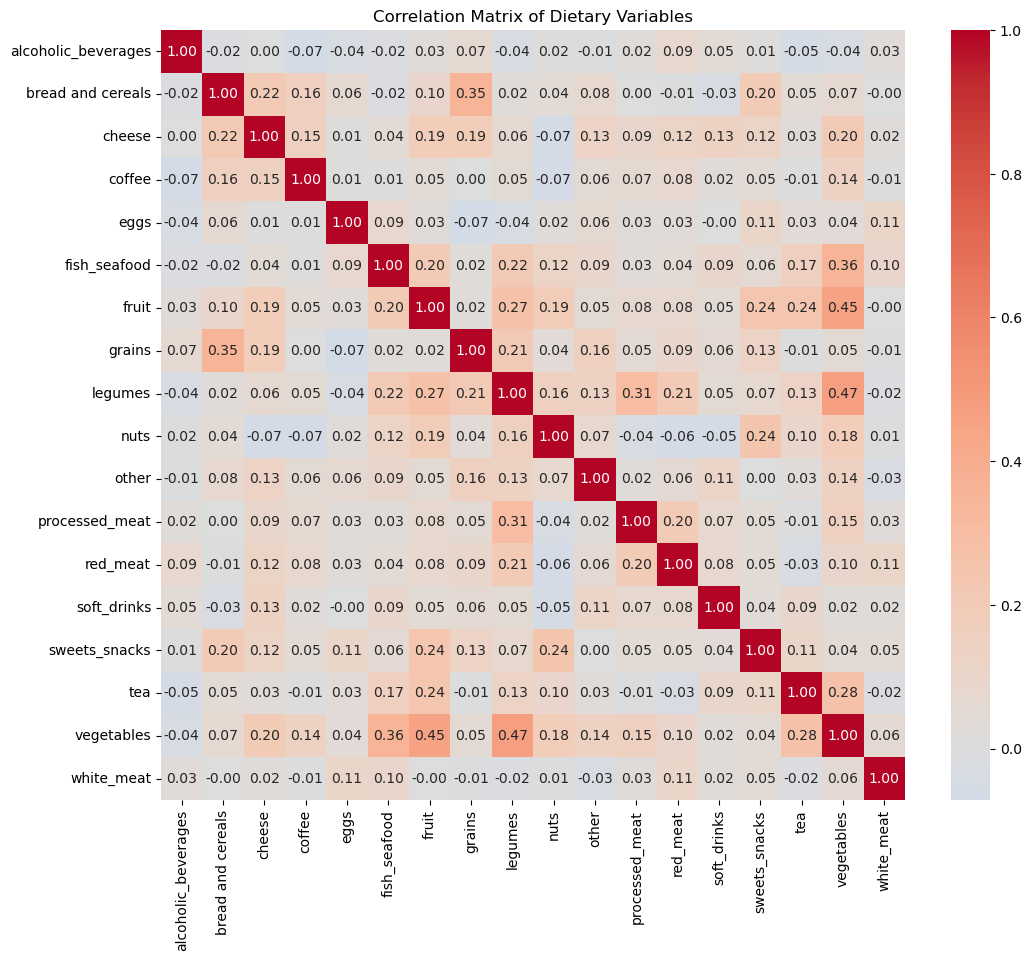

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr = df_gmm[diet_vars].corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Dietary Variables")
plt.show()

## Discovering dietary patterns with Gaussian Mixture Models (GMM)

## Use BIC and AIC 

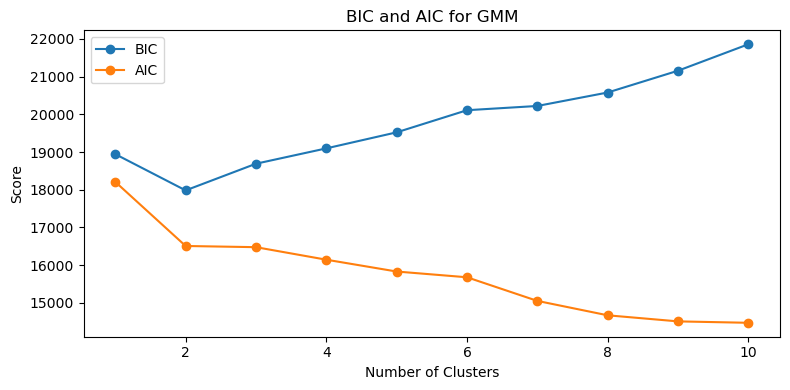

In [21]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_components = np.arange(1, 11)  # Try 1 to 10 clusters
bics = []
aics = []

for k in n_components:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_diet)  # Assuming your input data is scaled
    bics.append(gmm.bic(X_diet))
    aics.append(gmm.aic(X_diet))

# Plot BIC and AIC
plt.figure(figsize=(8, 4))
plt.plot(n_components, bics, label='BIC', marker='o')
plt.plot(n_components, aics, label='AIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('BIC and AIC for GMM')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters (latent classes)
n_components = 3  # You can try 2, 3, 4, etc. and compare AIC/BIC

gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(X_diet)

# Get cluster probabilities for each subject
pattern_probs = gmm.predict_proba(X_diet)

# Assign most likely pattern to each subject
pattern_labels = gmm.predict(X_diet)

df_gmm['diet_pattern'] = pattern_labels


## Explore and visualize the discovered patterns

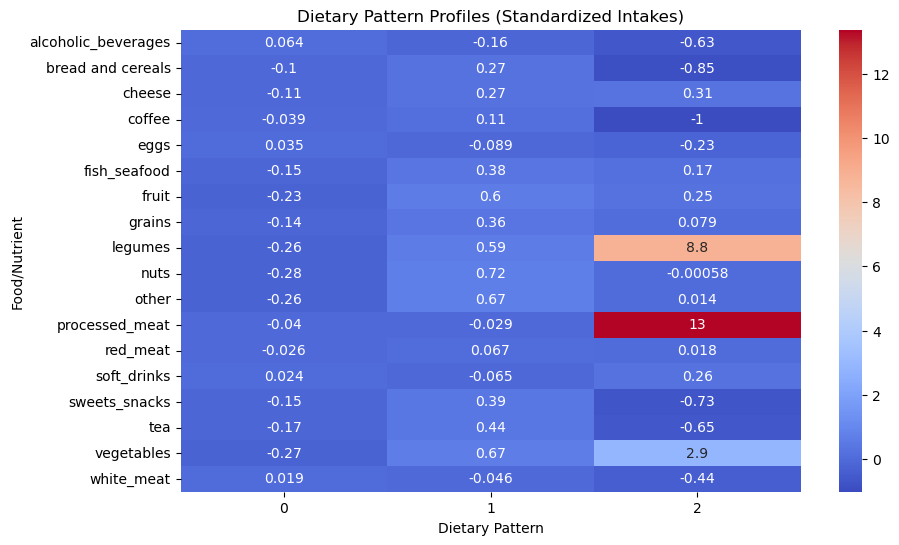

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

pattern_means = pd.DataFrame(gmm.means_, columns=diet_vars)

plt.figure(figsize=(10, 6))
sns.heatmap(pattern_means.T, annot=True, cmap='coolwarm')
plt.title('Dietary Pattern Profiles (Standardized Intakes)')
plt.xlabel('Dietary Pattern')
plt.ylabel('Food/Nutrient')
plt.show()


## LCA

### Conversion to cat vars

In [24]:

# Your original DataFrame
df_lca = aggregated_data.copy()
df_lca.head()

,bread and cereals,grains,red_meat,white_meat,processed_meat,fish_seafood,eggs,cheese,vegetables,legumes,...,other,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,2.643,1.852,0.424,0.067,0.357,0.234,0.067,1.605,1.021,0.099,...,0.176,3.660762,40.59,0,26.312811,7.61,1,1,1,2
1,0.500,0.700,0.424,0.357,0.143,0.419,0.143,1.429,2.595,1.204,...,0.210,1.796643,37.38,1,21.551020,11.64,0,0,0,0
2,0.643,2.067,0.714,0.357,0.033,1.201,0.143,0.600,3.725,0.667,...,0.067,2.465101,40.36,1,20.069204,8.61,1,0,0,0
3,1.357,0.667,0.357,0.357,0.357,0.386,0.143,1.634,4.792,0.308,...,1.033,3.133907,50.41,1,25.099502,29.62,0,1,0,1
4,1.033,1.200,0.143,0.067,0.033,0.590,0.357,2.204,4.381,0.853,...,0.067,2.794231,67.70,1,30.859375,13.18,0,0,0,1


In [25]:
# Function for quantile-based binning with 0 as separate category
def quantile_bin_with_zero(series, q=3):
    # Replace 0 with NaN temporarily so they don't affect quantiles
    non_zero = series[series > 0]
    
    # Perform qcut on non-zero values
    try:
        binned = pd.qcut(non_zero, q=q, labels=range(1, q+1), duplicates='drop')
    except ValueError:
        # Not enough unique values — fallback to single category
        binned = pd.Series(index=non_zero.index, data=1)
    
    # Create full series
    result = pd.Series(data=0, index=series.index)  # Start with zeros
    result.loc[binned.index] = binned.astype(int)   # Fill non-zeros
    return result


for col in diet_vars:
    df_lca[col] = quantile_bin_with_zero(df_lca[col], q=3)  #5 categories


# Add the DAS28 and confounders back to the DataFrame
df_lca['DAS28'] = aggregated_data['DAS28']
for confounder in confounders:
    df_lca[confounder] = aggregated_data[confounder]

df_lca.head()

,bread and cereals,grains,red_meat,white_meat,processed_meat,fish_seafood,eggs,cheese,vegetables,legumes,...,other,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,3,3,3,1,2,1,1,2,1,1,...,2,3.660762,40.59,0,26.312811,7.61,1,1,1,2
1,1,1,3,2,1,2,1,2,2,3,...,2,1.796643,37.38,1,21.551020,11.64,0,0,0,0
2,1,3,3,2,1,3,1,1,2,3,...,1,2.465101,40.36,1,20.069204,8.61,1,0,0,0
3,2,1,2,2,2,2,1,2,3,2,...,3,3.133907,50.41,1,25.099502,29.62,0,1,0,1
4,2,2,1,1,1,3,1,2,3,3,...,1,2.794231,67.70,1,30.859375,13.18,0,0,0,1


### LCA

In [26]:
# Extract only those columns
X_diet_lca = df_lca[diet_vars]

In [27]:
from stepmix.stepmix import StepMix

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 124.98it/s, max_LL=-7.59e+3, max_avg_LL=-21]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  5.62it/s, max_LL=-7.41e+3, max_avg_LL=-20.5]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  5.40it/s, max_LL=-7.31e+3, max_avg_LL=-20.2]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, max_LL=-7.25e+3, max_avg_LL=-20]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, max_LL=-7.2e+3, max_avg_LL=-19.9]


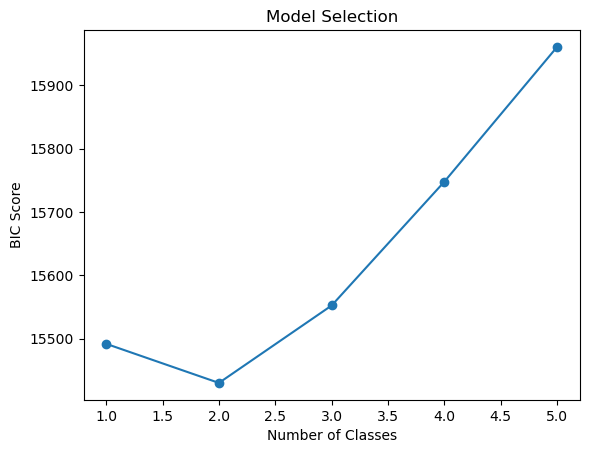

In [28]:
bic_scores = []
for k in range(1, 6):
    model = StepMix(n_components=k, measurement='categorical', n_steps=1, random_state=42)
    model.fit(X_diet_lca)
    bic_scores.append(model.bic(X_diet_lca))

import matplotlib.pyplot as plt
plt.plot(range(1, 6), bic_scores, marker='o')
plt.xlabel("Number of Classes")
plt.ylabel("BIC Score")
plt.title("Model Selection")
plt.show()


In [29]:
# Number of classes you want to try (e.g. 2, 3, or 4)
n_classes = 3

# Fit the LCA model
model = StepMix(n_components=n_classes, measurement='categorical', n_steps=1, verbose=1, random_state=42)
model.fit(X_diet_lca)

# Get predicted class (latent profile) for each individual
class_assignments = model.predict(X_diet_lca)

# Add class labels to your original dataframe
df_lca['diet_pattern_LCA'] = class_assignments


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, max_LL=-7.31e+3, max_avg_LL=-20.2]

MODEL REPORT
    Measurement model parameters
          model_name                  categorical                
          class_no                              0       1       2
          param variable                                         
          pis   alcoholic_beverages_0      0.1963  0.3792  0.3337
                alcoholic_beverages_1      0.2787  0.2200  0.1960
                alcoholic_beverages_2      0.2972  0.2066  0.2530
                alcoholic_beverages_3      0.2278  0.1943  0.2173
                bread and cereals_0        0.0000  0.0843  0.0702
                bread and cereals_1        0.3316  0.6112  0.3492
                bread and cereals_2        0.3520  0.0817  0.3182
                bread and cereals_3        0.3164  0.2228  0.2624
                cheese_0                   0.0000  0.0068  0.0582
                cheese_1                   0.2223  0.4688  0.2677
                cheese_2                   0.3603  0.2874  0.3656
                cheese_3      

In [30]:
df_lca.groupby('diet_pattern_LCA')[diet_vars].mean()

,alcoholic_beverages,bread and cereals,cheese,coffee,eggs,fish_seafood,fruit,grains,legumes,nuts,other,processed_meat,red_meat,soft_drinks,sweets_snacks,tea,vegetables,white_meat
diet_pattern_LCA,,,,,,,,,,,,,,,,,,
0,1.544910,1.976048,2.203593,1.694611,0.952096,2.245509,2.263473,2.209581,2.137725,1.922156,1.952096,1.838323,2.179641,1.994012,2.149701,1.718563,2.227545,1.646707
1,1.205479,1.445205,1.746575,1.424658,0.938356,1.534247,1.534247,1.726027,1.479452,1.239726,1.205479,1.417808,1.760274,0.842466,1.650685,1.082192,1.472603,1.541096
2,1.408163,1.775510,1.897959,1.673469,0.836735,2.224490,2.469388,1.897959,2.816327,2.244898,1.795918,0.979592,1.081633,1.673469,2.000000,2.163265,2.795918,1.122449


In [31]:
df_lca['diet_pattern_LCA'].value_counts()

diet_pattern_LCA
0    167
1    146
2     49
Name: count, dtype: int64

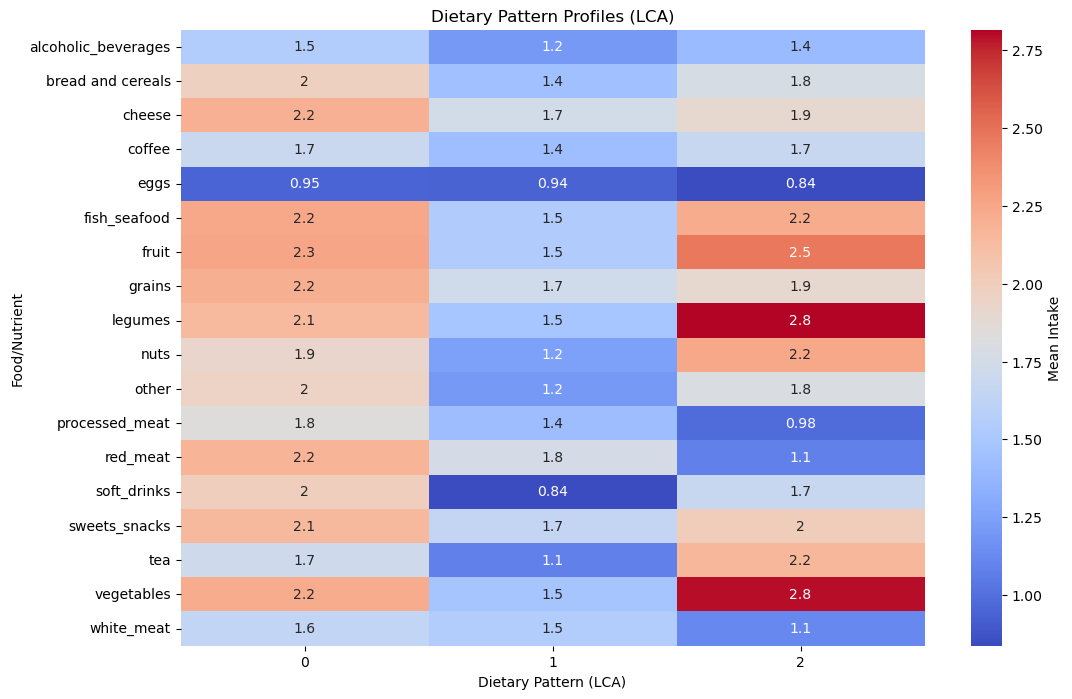

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
# Prepare data for plotting
pattern_means_lca = df_lca.groupby('diet_pattern_LCA')[diet_vars].mean().T
plt.figure(figsize=(12, 8))
sns.heatmap(pattern_means_lca, annot=True, cmap='coolwarm', cbar_kws={'label': 'Mean Intake'})
plt.title('Dietary Pattern Profiles (LCA)')
plt.xlabel('Dietary Pattern (LCA)')
plt.ylabel('Food/Nutrient')
plt.show()

## OLS with GMM

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
df_gmm.head()

,bread and cereals,grains,red_meat,white_meat,processed_meat,fish_seafood,eggs,cheese,vegetables,legumes,...,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore,diet_pattern
0,2.643,1.852,0.424,0.067,0.357,0.234,0.067,1.605,1.021,0.099,...,3.660762,40.59,0,26.312811,7.61,1,1,1,2,0
1,0.500,0.700,0.424,0.357,0.143,0.419,0.143,1.429,2.595,1.204,...,1.796643,37.38,1,21.551020,11.64,0,0,0,0,1
2,0.643,2.067,0.714,0.357,0.033,1.201,0.143,0.600,3.725,0.667,...,2.465101,40.36,1,20.069204,8.61,1,0,0,0,0
3,1.357,0.667,0.357,0.357,0.357,0.386,0.143,1.634,4.792,0.308,...,3.133907,50.41,1,25.099502,29.62,0,1,0,1,1
4,1.033,1.200,0.143,0.067,0.033,0.590,0.357,2.204,4.381,0.853,...,2.794231,67.70,1,30.859375,13.18,0,0,0,1,0


In [ ]:
df_gmm['diet_pattern'] = df_gmm['diet_pattern'].astype('category')

# Define confounders after encoding
confounders = [
    'BMI',
    'ETA_VISITA',
    'DURATA_MALATTIA',
    'Fattore_reumatoide',
    'STEROIDI',
    'bDMARDs',
    'SESSO',
    'Fumatore'
]

formula = 'DAS28 ~ C(diet_pattern) + ' + ' + '.join(confounders)
model = smf.ols(formula=formula, data=df_gmm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  DAS28   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     5.280
Date:                Wed, 28 May 2025   Prob (F-statistic):           2.98e-07
Time:                        13:32:05   Log-Likelihood:                -527.70
No. Observations:                 362   AIC:                             1077.
Df Residuals:                     351   BIC:                             1120.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.4213 

In [ ]:
from statsmodels.stats.anova import anova_lm
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(diet_pattern),2.0,1.540238,0.770119,0.690958,5.017759e-01
BMI,1.0,10.281518,10.281518,9.224680,2.566442e-03
ETA_VISITA,1.0,0.007243,0.007243,0.006498,9.357972e-01
DURATA_MALATTIA,1.0,5.843499,5.843499,5.242845,2.263013e-02
Fattore_reumatoide,1.0,0.000321,0.000321,0.000288,9.864628e-01
STEROIDI,1.0,31.456570,31.456570,28.223146,1.924548e-07
bDMARDs,1.0,9.437337,9.437337,8.467272,3.846549e-03
SESSO,1.0,0.285031,0.285031,0.255733,6.133845e-01
Fumatore,1.0,0.000024,0.000024,0.000022,9.962781e-01
Residual,351.0,391.212806,1.114566,NaN,NaN


Based on both the OLS coefficients and the ANOVA, the answer is no — there's no significant effect of dietary patterns on DAS28 after adjusting for confounders.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = model.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
print(vif_data)


                 feature        VIF
0              Intercept  60.455740
1   C(diet_pattern)[T.1]   1.044467
2   C(diet_pattern)[T.2]   1.024978
3                    BMI   1.041791
4             ETA_VISITA   1.159707
5        DURATA_MALATTIA   1.118998
6     Fattore_reumatoide   1.077440
7               STEROIDI   1.031727
8                bDMARDs   1.032152
9                  SESSO   1.113808
10              Fumatore   1.077821


## OLS with LCA

In [ ]:
# OLS with LCA patterns
df_lca['diet_pattern_LCA'] = df_lca['diet_pattern_LCA'].astype('category')
formula_lca = 'DAS28 ~ C(diet_pattern_LCA) + ' + ' + '.join(confounders)
model_lca = smf.ols(formula=formula_lca, data=df_lca).fit()
print(model_lca.summary())

                            OLS Regression Results                            
Dep. Variable:                  DAS28   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     5.239
Date:                Wed, 28 May 2025   Prob (F-statistic):           3.47e-07
Time:                        13:32:05   Log-Likelihood:                -527.89
No. Observations:                 362   AIC:                             1078.
Df Residuals:                     351   BIC:                             1121.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               